<a href="https://colab.research.google.com/github/hauduong05/NER_Extract_CV/blob/main/Extract_CV_BiLSTM_CRF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install torchkeras

In [ ]:
!pip install pytorch-crf

In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import time
from tqdm import tqdm
from keras.preprocessing.sequence import pad_sequences
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, \
                            confusion_matrix, classification_report
import torchkeras
from torchcrf import CRF

In [ ]:
# read data

header_names = ['Word', 'POS', 'Chunking-Tag', 'Tag']

train_dt = pd.read_csv('/content/drive/MyDrive/NER/train-1.csv', sep=r'\t', names=header_names)
val_dt = pd.read_csv('/content/drive/MyDrive/NER/dev-1.csv', sep=r'\t', names=header_names)
test_dt = pd.read_csv('/content/drive/MyDrive/NER/test-1.csv', sep=r'\t', names=header_names)

data = pd.concat([train_dt, val_dt, test_dt])
print(data)

In [ ]:
# handing missing value

print(data.isnull().sum())

data = data.fillna(method='ffill')
train_dt = train_dt.fillna(method='ffill')
test_dt = test_dt.fillna(method='ffill')
val_dt = val_dt.fillna(method='ffill')

In [ ]:
# group into sentence

def get_sentence(dt):
  id = 0
  sent = []
  w = dt['Word'].values
  for i in range(len(w)):
    sent.append(id)
    if w[i] == '.':
      id += 1
  dt['Sentence'] = sent
  return dt

def split_sentence(dt):
  dt = get_sentence(dt)
  sent = dt.groupby('Sentence')[['Word', 'POS', 'Tag']].apply(lambda s: s.values.tolist())
  return sent

data_sent = split_sentence(data)
print(data_sent)

Sentence
0         [[Tạo, V, O], [các, L, O], [Module_Agent, Np, ...
1         [[Từ, E, O], [3, M, O], [/, N, O], [2017, N, O...
2         [[Vị_Trí, Np, O], [:, CH, O], [Nhân_viên, N, B...
3         [[kỹ_năng, N, O], [sử_dụng, V, O], [thành_thạo...
4         [[Số, N, O], [ĐT, Ny, O], [ngưi, A, O], [qun, ...
                                ...                        
108217    [[Nghiên_cứu, N, O], [công_nghệ, N, O], [lưu_t...
108218    [[5.5, N, O], [>, N, O], [6.5, M, O], [,, CH, ...
108219    [[Bảo_trì, N, O], [Hệ_thống, N, O], [MAM, Np, ...
108220    [[Import, Np, O], [dữ_liệu, N, O], [và, C, O],...
108221    [[Troubleshoots, Np, O], [kết_nối_mạng, V, O],...
Length: 108222, dtype: object


In [ ]:
# initial hyper_paremeters

batch_size = 128
n_epochs = 6
embed_dim = 100
hidden_dim = 128
lr = 0.001
maxlen = 150

In [ ]:
# prepare data

words = data['Word'].unique()
tags = data['Tag'].unique()

word_to_id = {w : i + 2 for i, w in enumerate(words)}
word_to_id['<pad>'] = 0
word_to_id['<unk>'] = 1

tag_to_id = {t: i + 1 for i, t in enumerate(tags)}
tag_to_id['<pad>'] = 0
num_tags = len(tag_to_id)

print(tags)

def prepare_data(sent, maxlen):
  w2id = [[word_to_id[w[0]] for w in s] for s in sent]
  t2id = [[tag_to_id[t[2]] for t in s] for s in sent]

  X = pad_sequences(w2id, maxlen=maxlen, padding='post', value=0)
  y = pad_sequences(t2id, maxlen=maxlen, padding='post', value=0)
  X = torch.from_numpy(X).type(torch.long)
  y = torch.from_numpy(y).type(torch.long)
  return X, y

train_sent = split_sentence(train_dt)
val_sent = split_sentence(val_dt)
test_sent = split_sentence(test_dt)

X_train, y_train = prepare_data(train_sent, maxlen)
X_val, y_val = prepare_data(val_sent, maxlen)
X_test, y_test = prepare_data(test_sent, maxlen)

train = TensorDataset(X_train, y_train)
val = TensorDataset(X_val, y_val)
test = TensorDataset(X_test, y_test)

train_loader = DataLoader(train, batch_size = batch_size, shuffle=False, num_workers=4)
val_loader = DataLoader(val, batch_size = batch_size, shuffle=False, num_workers=4)
test_loader = DataLoader(test, batch_size = batch_size, shuffle=False, num_workers=4)

['O' 'B-SKILL' 'B-POS' 'I-POS' 'B-COM' 'I-COM' 'I-SKILL']


In [ ]:
class BiLSTM(nn.Module):
  def __init__(self, vocab_size, hidden_dim):
    super(BiLSTM, self).__init__()
    self.vocab_size = vocab_size
    self.hidden_dim = hidden_dim
    self.embeds = nn.Embedding(self.vocab_size, embed_dim)
    self.lstm = nn.LSTM(embed_dim, self.hidden_dim//2, bidirectional=True, batch_first=True)
    self.hidden2tag = nn.Linear(self.hidden_dim, num_tags)
    self.crf = CRF(num_tags, batch_first=True)
    
  def init_hidden(self, batch_size):

    return (torch.randn(2, batch_size, self.hidden//2), 
            torch.randn(2, batch_size, self.hidden//2))
    
  def forward(self, inp):
    self.lstm.flatten_parameters()
    embeds = self.embeds(inp)
    lstm_out, _ = self.lstm(embeds, None)
    feats = self.hidden2tag(lstm_out)

    return feats
    
  def crf_nll(self, inp, tags, mask=None, inp_feats=False):
    if inp_feats:
      feats = inp
    else:
      feats = self.forward(inp)
    
    if mask is None:
      mask = torch.logical_not(torch.eq(tags, torch.tensor(0)))
      mask = mask.type(torch.uint8)
    crf_llh = self.crf(feats, tags, mask, reduction='mean')

    return -crf_llh

  def crf_decode(self, inp, mask=None, inp_feats=False):
    if inp_feats:
      feats = inp
    else:
      feats = self.forward(inp)
    
    if mask is None and inp_feats is False:
      mask = torch.logical_not(torch.eq(inp, torch.tensor(0)))
      mask = mask.type(torch.uint8)

    return self.crf.decode(emissions=feats, mask=mask)

In [ ]:
model = BiLSTM(len(word_to_id), hidden_dim)
torchkeras.summary(model, input_shape = (150,), input_dtype = torch.int64)

In [ ]:
metric_func = lambda y_pred, y_true: accuracy_score(y_pred, y_true)
df_history = pd.DataFrame(columns=['epoch', 'loss', 'acc', 'val_loss', 'val_acc'])

In [ ]:
def train_step(model, inp, tags, optimizer):
  inp = inp
  tags = tags
  mask = torch.logical_not(torch.eq(inp, torch.tensor(0)))
  model.train()
  optimizer.zero_grad()
  feats = model(inp)
  loss = model.crf_nll(feats, tags, mask=mask, inp_feats=True)
  loss.backward()
  optimizer.step()

  preds = model.crf_decode(feats, mask=mask, inp_feats=True)
  preds_without_pad = []
  for pred in preds:
    preds_without_pad.extend(pred)
  tags_without_pad = torch.masked_select(tags, mask).numpy()
  metric = metric_func(preds_without_pad, tags_without_pad)
  
  return loss.item(), metric

In [ ]:
@torch.no_grad()
def val_step(model, inp, tags):
  inp = inp
  tags = tags
  mask = torch.logical_not(torch.eq(inp, torch.tensor(0)))
  model.eval()

  feats = model(inp)
  loss = model.crf_nll(feats, tags, mask=mask, inp_feats=True)

  preds = model.crf_decode(feats, mask=mask, inp_feats = True)
  preds_without_pad = []
  for pred in preds:
    preds_without_pad.extend(pred)

  tags_without_pad = torch.masked_select(tags, mask).numpy()
  metric = metric_func(preds_without_pad, tags_without_pad)

  return loss.item(), metric

In [ ]:
def train_model(model, train_loader, val_loader, optimizer, n_epochs):
  for epoch in range(1, n_epochs + 1):
    loss_sum, metric_sum = 0.0, 0.0
    for step, (inp, tags) in enumerate(train_loader, start=1):
      loss, metric = train_step(model, inp, tags, optimizer)
      loss_sum += loss
      metric_sum += metric
      if step % 100 == 0:
        print('*' * 20, f"step = {step}, loss : {loss_sum/step:.3f}, acc : {metric_sum/step:.3f}")
      
    val_loss_sum , val_acc_sum = 0.0, 0.0
    for valid_step, (inp, tags) in enumerate(val_loader, start=1):
      loss, metric = val_step(model, inp, tags)
      val_loss_sum += loss
      val_acc_sum += metric

    record = (epoch, loss_sum/step, metric_sum/step, val_loss_sum/valid_step, val_acc_sum/valid_step)
    df_history.loc[epoch-1] = record

    print('epoch = {}, loss: {:.3f}, acc: {:.3f}, val_loss: {:.3f}, val_acc: {:.3f}'.format(
        record[0], record[1], record[2], record[3], record[4]))
  
  return df_history

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
train_model(model, train_loader, val_loader, optimizer, n_epochs)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


******************** step = 100, loss : 4.623, acc : 0.899
******************** step = 200, loss : 3.917, acc : 0.914
******************** step = 300, loss : 3.527, acc : 0.919
******************** step = 400, loss : 3.230, acc : 0.923
******************** step = 500, loss : 3.003, acc : 0.927
******************** step = 600, loss : 2.841, acc : 0.930
epoch = 1, loss: 2.760, acc: 0.931, val_loss: 1.816, val_acc: 0.953
******************** step = 100, loss : 1.779, acc : 0.946
******************** step = 200, loss : 1.709, acc : 0.949
******************** step = 300, loss : 1.695, acc : 0.948
******************** step = 400, loss : 1.650, acc : 0.949
******************** step = 500, loss : 1.607, acc : 0.950
******************** step = 600, loss : 1.580, acc : 0.950
epoch = 2, loss: 1.560, acc: 0.951, val_loss: 1.473, val_acc: 0.956
******************** step = 100, loss : 1.315, acc : 0.954
******************** step = 200, loss : 1.274, acc : 0.956
******************** step = 300, loss 

,epoch,loss,acc,val_loss,val_acc
0,1.0,2.760213,0.931066,1.816104,0.952717
1,2.0,1.559732,0.950529,1.472561,0.955572
2,3.0,1.207987,0.956666,1.330720,0.956321
3,4.0,0.999133,0.961464,1.265869,0.956299
4,5.0,0.853172,0.965890,1.247306,0.956331
5,6.0,0.740432,0.969600,1.252497,0.955956


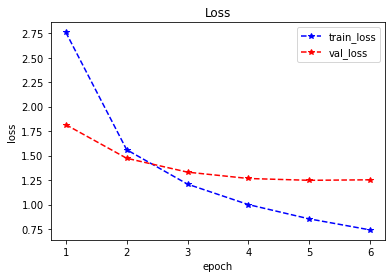

In [ ]:
plt.figure()
train_loss = df_history['loss']
val_loss = df_history['val_loss']
epoch = range(1, n_epochs + 1)
plt.plot(epoch, train_loss, 'b*--')
plt.plot(epoch, val_loss, 'r*--')
plt.title('Loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train_loss', 'val_loss'])
plt.show()

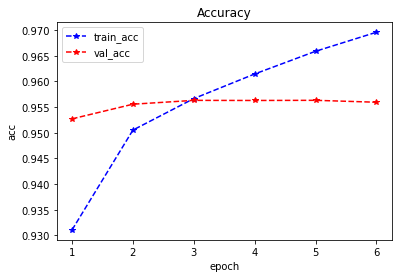

In [ ]:
train_acc = df_history['acc']
val_acc = df_history['val_acc']
epoch = range(1, n_epochs + 1)
plt.plot(epoch, train_acc, 'b*--')
plt.plot(epoch, val_acc, 'r*--')
plt.title('Accuracy')
plt.xlabel('epoch')
plt.ylabel('acc')
plt.legend(['train_acc', 'val_acc'])
plt.show()

In [ ]:
@torch.no_grad()
def eval_step(model, inps, tags):
    inps = inps
    tags = tags
    mask = torch.logical_not(torch.eq(inps, torch.tensor(0)))  
    
    feats = model(inps)
    preds = model.crf_decode(feats, mask=mask, inp_feats=True)  
    pred_without_pad = []
    for pred in preds:
        pred_without_pad.extend(pred)
    tags_without_pad = torch.masked_select(tags, mask) 

    return torch.tensor(pred_without_pad), tags_without_pad

In [ ]:
def evaluate(model, test_loader):
    model.eval()  
    
    print('*' * 20, 'start evaluating...')
    preds, labels = [], []
    for step, (inps, tags) in enumerate(test_loader, start=1):
        pred, tags = eval_step(model, inps, tags)
        preds.append(pred)
        labels.append(tags)

    y_true = torch.cat(labels, dim=0)
    y_pred = torch.cat(preds, dim=0)
    
    return y_true, y_pred

In [ ]:
def get_metrics(y_true, y_pred):
    average = 'macro'
    print('*'*27, average+'_precision_score:{:.3f}'.format(precision_score(y_true, y_pred, average=average)))
    print('*'*27, average+'_recall_score:{:.3}'.format(recall_score(y_true, y_pred, average=average)))
    print('*'*27, average+'_f1_score:{:.3f}'.format(f1_score(y_true, y_pred, average=average)))

    print('*'*27, 'accuracy:{:.3f}'.format(accuracy_score(y_true, y_pred)))
    print('*'*27, 'confusion_matrix:\n', confusion_matrix(y_true, y_pred))
    print('*'*27, ' classification_report: \n', classification_report(y_true, y_pred, target_names=tags))

In [ ]:
y_true, y_pred = evaluate(model, test_loader)
get_metrics(y_true, y_pred)

******************** start evaluating...


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


*************************** macro_precision_score:0.810
*************************** macro_recall_score:0.727
*************************** macro_f1_score:0.759
*************************** accuracy:0.950
*************************** confusion_matrix:
 [[226420    653    266    802    357   1297    502]
 [  3677   5775     10     36      7     17    197]
 [   434     12   1484     56      8     20      0]
 [   644     18     32   1906      6     21     14]
 [   549      3     13     35   1935     63      1]
 [   928      2      5     61     34   6266      4]
 [  2007     94      0     19      1     13   1752]]
***************************  classification_report: 
               precision    recall  f1-score   support

           O       0.96      0.98      0.97    230297
     B-SKILL       0.88      0.59      0.71      9719
       B-POS       0.82      0.74      0.78      2014
       I-POS       0.65      0.72      0.69      2641
       B-COM       0.82      0.74      0.78      2599
       I